In [38]:
import sys
import numpy as np
from sys import stdout
from scipy.spatial import distance
from numpy import linalg
from sklearn import svm, grid_search
import matplotlib.pyplot as plt
from sklearn import hmm

%matplotlib inline

NUM_WORDS = 7
NUM_COEFFS = 13
NUM_WINDOWS = 83

## Data Processing

In [3]:
_data = {}
_label_data = {}

# create example -> info mapping
with open('competition_2/train.data', 'r') as data_file:
    for i, line in enumerate(data_file):
        _data[i] = {}
        _data[i]['data'] = []

        coeffs = line.split(',')
        for k in xrange(0, len(coeffs), NUM_COEFFS):
            _data[i]['data'].append(np.array([float(num) for num in coeffs[k:k+13]]))
    
with open('competition_2/train.labels', 'r') as label_file:
    for i, line in enumerate(label_file):
        if i == 0: continue
        vals = line.split(',')
        pt = int(vals[0])
        label = int(vals[1])
        _data[pt]['label'] = label
        
# create label -> data mapping
for i, val in _data.iteritems():
    label = val['label']
    data = val['data']
    if label not in _label_data:
        _label_data[label] = []
    _label_data[label].append(data)
        
NUM_EXAMPLES = len(_data)
print NUM_EXAMPLES, len(_label_data)
print 'done'


4620 7
done


## Class Probabilities with conditional cosine sim 

In [114]:
# get average cosine similarities with every training point
# args: vector of observation coefficients, vector of example coefficients
def get_example_dist(obs_vec, example):
    example_dist = 0

    # iterate through windows and add log similarities
    for window in range(len(example)):
#         print "window " + str(window)
#         print obs_vec[window], example[window]
#         print linalg.norm(obs_vec[window]), linalg.norm(example[window])
#         print np.dot(obs_vec[window], example[window])
#         print distance.cosine(obs_vec[window], example[window])
        
        if linalg.norm(obs_vec[window] != 0) and linalg.norm(example[window]) != 0:
            example_dist += distance.cosine(obs_vec[window], example[window])
#         print example_dist
        
    return example_dist

# test
print get_example_dist(_data[0]['data'], _data[1]['data'])

10.6455505697


In [121]:
def evaluate_observations(obs_vec):
    dists = [0 for i in range(NUM_WORDS)]
    for word in range(NUM_WORDS):
        # find the probability that the observation is this word
        examples = _label_data[word]
        num_examples = len(examples)
        avg_dist = 0.0
        
        # iterate through examples and get average log probability
        for example in examples:
            avg_dist += get_example_dist(obs_vec, example)
            
        avg_dist /= num_examples
        dists[word] = avg_dist
    return dists

## Predictions

In [124]:
with open('competition_2/train.data', 'r') as test_data:
    for i, line in enumerate(test_data):
        if i < 700: continue
        obs_vec = []
        coeffs = line.split(',')
        for k in xrange(0, len(coeffs), NUM_COEFFS):
            obs_vec.append(np.array([float(num) for num in coeffs[k:k+13]]))
        
        print evaluate_observations(obs_vec)
        break

[13.591426311957827, 13.439150272035237, 15.409914786843604, 19.99527797810735, 12.739804626894834, 20.224360916076598, 15.16685856025695]


## SVM

In [16]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)

X = []
Y = []
for k, v in _data.iteritems():
    X.append(np.array(v['data']).flatten())
    Y.append(v['label'])
    
print 'fitting...'
clf.fit(X, Y)

fitting...


GridSearchCV(cv=None,
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [28]:
test_vectors = []
with open('competition_2/test.data', 'r') as test_data:
    for i, line in enumerate(test_data):
#         obs_vec = []
        coeffs = line.split(',')
#         for k in xrange(0, len(coeffs), NUM_COEFFS):
#             obs_vec.append(np.array([float(num) for num in coeffs[k:k+13]]))
        
        test_vectors.append([float(val) for val in coeffs])

print len(test_vectors)
predictions = clf.predict(test_vectors)

1540


0.975324675325
{0: 220, 1: 219, 2: 217, 3: 220, 4: 220, 5: 220, 6: 224}


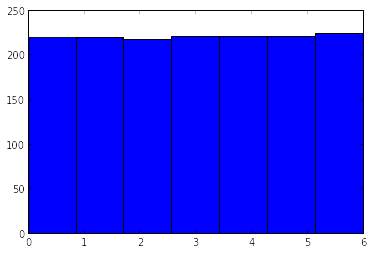

In [29]:
correct = 0.0

with open('97.csv', 'r') as good_preds_data:
    for i, line in enumerate(good_preds_data):
        if i == 0: continue
        vals = line.split(',')
        id = int(vals[0])
        good_pred = int(vals[1])
        
        if predictions[id] == good_pred:
            correct += 1

# for i, pred in enumerate(predictions):
#     if _data[i]['label'] == pred:
#         correct += 1

print correct / len(predictions)

plt.hist(predictions, bins = 7)

counts = {}
for pred in predictions:
    if pred not in counts:
        counts[pred] = 0
    counts[pred] += 1

print counts

In [20]:
# output file
with open('svm_preds.txt', 'w') as svm_preds_file:
    svm_preds_file.write('Id,Prediction\n')
    for i, pred in enumerate(predictions):
        svm_preds_file.write(str(i) + ',' + str(pred)+'\n')

## Linear SVC Classifier

In [36]:
parameters = {'C':[1, 10]}
lin_svc = svm.LinearSVC(penalty='l1', dual=False)
lin_clf = grid_search.GridSearchCV(lin_svc, parameters)

print 'fitting...'
lin_clf.fit(X, Y)
print 'done'

fitting...
done


(array([219, 224, 213, 211, 221, 220, 232]),
 array([ 0.        ,  0.85714286,  1.71428571,  2.57142857,  3.42857143,
         4.28571429,  5.14285714,  6.        ]),
 <a list of 7 Patch objects>)

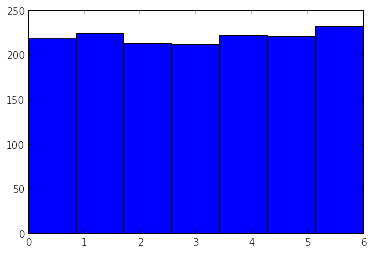

In [37]:
# predict
predictions_lin = lin_clf.predict(test_vectors)

# plot
plt.hist(predictions_lin, bins=7)

##HMM Classifier

In [92]:
models = {}
for word in range(7):
    models[word] = hmm.GaussianHMM(6, "full")
    models[word].fit(np.array(_label_data[word]))
# print np.array(_label_data[0]).shape

# training_data = []
# for ex in _label_data[0]:
#     print np.array(ex).flatten().shape
#     training_data.append(np.array(ex).flatten())

# print np.array(training_data).shape

# model2.fit(np.array(training_data)[0])

/Library/Python/2.7/site-packages/sklearn/utils/__init__.py:75: DeprecationWarning: Class _BaseHMM is deprecated; WARNING: The HMM module and its function will be removed in 0.17as it no longer falls within the project's scope and API. It has been moved to a separate repository: https://github.com/hmmlearn/hmmlearn
  warnings.warn(msg, category=DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function normalize is deprecated; WARNING: The HMM module and its functions will be removed in 0.17 as it no longer falls within the project's scope and API. It has been moved to a separate repository: https://github.com/hmmlearn/hmmlearn
  warnings.warn(msg, category=DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function normalize is deprecated; WARNING: The HMM module and its functions will be removed in 0.17 as it no longer falls within the project's scope and API. It has been moved 

(array([  2,   3,  15,  27,  45, 121, 180, 171,  82,  14]),
 array([ 1079.18171173,  1526.09429566,  1973.00687959,  2419.91946352,
         2866.83204745,  3313.74463138,  3760.65721531,  4207.56979924,
         4654.48238316,  5101.39496709,  5548.30755102]),
 <a list of 10 Patch objects>)

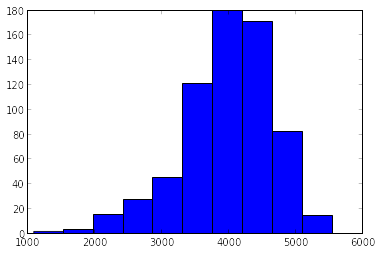

In [71]:
scores = []
for ex in _label_data[0]:
    scores.append(model2.score(ex))
plt.hist(scores)

(array([  5,   3,  10,  20,  69, 128, 155, 183,  71,  16]),
 array([ -904.80172368,  -401.65970018,   101.48232332,   604.62434682,
         1107.76637031,  1610.90839381,  2114.05041731,  2617.19244081,
         3120.33446431,  3623.47648781,  4126.6185113 ]),
 <a list of 10 Patch objects>)

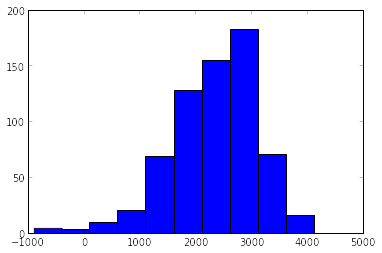

In [73]:
scores = []
for ex in _label_data[4]:
    scores.append(model2.score(ex))
plt.hist(scores)

(array([ 1,  2,  1,  3,  4,  7, 13, 16, 17, 15, 30, 25, 45, 41, 41, 36, 36,
        49, 53, 43, 47, 29, 23, 13, 17,  6,  9, 11,  6,  5,  4,  3,  1,  3,
         1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1]),
 array([-64.82423088, -61.79812986, -58.77202883, -55.74592781,
        -52.71982679, -49.69372576, -46.66762474, -43.64152372,
        -40.61542269, -37.58932167, -34.56322064, -31.53711962,
        -28.5110186 , -25.48491757, -22.45881655, -19.43271553,
        -16.4066145 , -13.38051348, -10.35441246,  -7.32831143,
         -4.30221041,  -1.27610939,   1.74999164,   4.77609266,
          7.80219368,  10.82829471,  13.85439573,  16.88049675,
         19.90659778,  22.9326988 ,  25.95879983,  28.98490085,
         32.01100187,  35.0371029 ,  38.06320392,  41.08930494,
         44.11540597,  47.14150699,  50.16760801,  53.19370904,
         56.21981006,  59.24591108,  62.27201211,  65.29811313,
         68.32421415,  71.35031518,  74.3764162 ,  77.40251723,
      

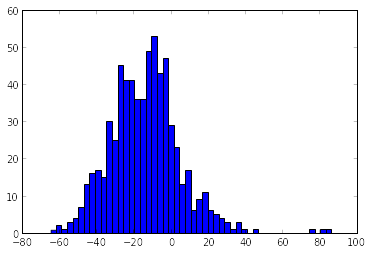

In [91]:
scores_1 = []
for ex in _label_data[0]:
    scores_1.append(models[0].score(ex) - models[1].score(ex))
plt.hist(scores_1, bins=50)

In [93]:
test_vectors_windows = []
with open('competition_2/test.data', 'r') as test_data:
    for i, line in enumerate(test_data):
        obs_vec = []
        coeffs = line.split(',')
        for k in xrange(0, len(coeffs), NUM_COEFFS):
            obs_vec.append(np.array([float(num) for num in coeffs[k:k+13]]))
        
        test_vectors_windows.append(obs_vec)
#         test_vectors_windows.append([float(val) for val in coeffs])

print len(test_vectors_windows)

1540


In [95]:
hmm_preds = []
for i, test in enumerate(_label_data[1]):
    max_score = 0
    best_pred = None
    for word in range(7):
        test_score = models[word].score(test)
        if best_pred == None or test_score > max_score:
            max_score = test_score
            best_pred = word
    hmm_preds.append(best_pred)
            
print hmm_preds

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 